In [1]:
import pathlib
import time
import json

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import itertools

In [2]:
train_data_filepath = pathlib.Path('data/fashion-mnist_train.csv') 
test_data_filepath = pathlib.Path('data/fashion-mnist_test.csv')


In [3]:
torch.manual_seed(0)

In [4]:
train_data = pl.read_csv(
    train_data_filepath,
    # n_rows = 1000,
)

test_data = pl.read_csv(
    test_data_filepath,
    # n_rows = 1000,
)

In [5]:
# Custom Dataset class
class MnistFashionDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx].reshape(28, 28).astype('float32')
        label = self.targets[idx].astype('float32')
        return torch.tensor(image), torch.tensor(label)

In [6]:
# Train Set

train_feature_data = train_data.select(
    pl.col(train_data.columns[1:])
).with_columns(
    pl.all()/255.0
)


train_target_data = train_data.select(
    pl.col(train_data.columns[0])
).cast(
    pl.Int32
).to_dummies()

X = train_feature_data.to_numpy()
y = train_target_data.to_numpy()

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size= 1/8,
    random_state= 42
)


# Test Set
test_feature_data = test_data.select(
    pl.col(test_data.columns[1:])
).with_columns(
    pl.all()/255.0
)


test_target_data = test_data.select(
    pl.col(test_data.columns[0])
).cast(
    pl.Int32
).to_dummies()

X_test = test_feature_data.to_numpy()
y_test = test_target_data.to_numpy()


# Create Dataset objects
train_dataset = MnistFashionDataset( X_train, y_train)
test_dataset = MnistFashionDataset( X_test, y_test)
val_dataset = MnistFashionDataset( X_val, y_val)


In [7]:
val_dataset.__len__()

7500

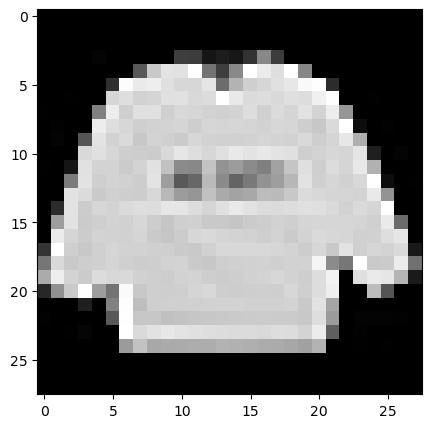

In [8]:
test_image = train_feature_data[0].to_numpy().reshape(28, 28)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(
    test_image,
    cmap='gray', 
    vmin=0, 
    vmax=1
)

plt.show()

In [9]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relufc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.fc1(x)
        x = self.relufc(x)
        x = self.fc2(x)
        return x

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 10
batch_size = 32
learning_rate = 0.001
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [11]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
)
val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

### Baseline Model Accuracy and training Time

In [12]:
model = SimpleCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

training_history = []
for epoch in range(num_epochs):
    model.train()
    running_training_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device).unsqueeze(1), labels.to(device)  # Add channel dimension
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()

    training_loss = running_training_loss / len(train_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Training',
        'loss': training_loss
    })
    
    # Validation step
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device).unsqueeze(1), labels.to(device)  # Add channel dimension
            # optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            # loss.backward()
            running_val_loss += loss.item()
            
    validation_loss = running_val_loss / len(val_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Validation',
        'loss': validation_loss
    })

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f' - Training for {num_epochs} epochs took {elapsed_time:.2f} seconds.')

Epoch [1/10], Training Loss: 0.5110, Validation Loss: 0.3813
Epoch [2/10], Training Loss: 0.3327, Validation Loss: 0.3053
Epoch [3/10], Training Loss: 0.2828, Validation Loss: 0.2812
Epoch [4/10], Training Loss: 0.2508, Validation Loss: 0.2608
Epoch [5/10], Training Loss: 0.2254, Validation Loss: 0.2649
Epoch [6/10], Training Loss: 0.2002, Validation Loss: 0.2431
Epoch [7/10], Training Loss: 0.1795, Validation Loss: 0.2600
Epoch [8/10], Training Loss: 0.1623, Validation Loss: 0.2630
Epoch [9/10], Training Loss: 0.1489, Validation Loss: 0.2719
Epoch [10/10], Training Loss: 0.1334, Validation Loss: 0.2730
 - Training for 10 epochs took 42.20 seconds.


Loss should be going down
validation loss: if when it get's to a point it starts to go up it is overfitting

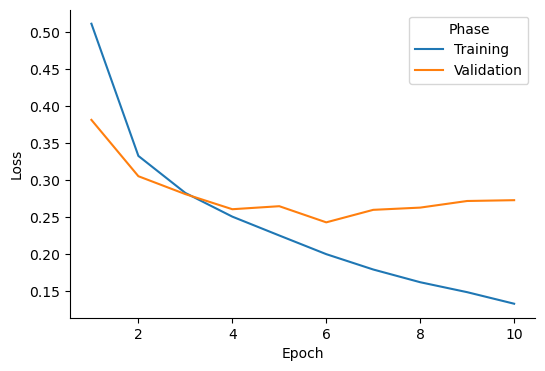

In [13]:
training_history_df = pl.DataFrame(training_history)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(
    training_history_df,
    x='epoch',
    y='loss',
    hue='phase',
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(title='Phase')
ax.spines[['right', 'top']].set_visible(False)

In [14]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device).unsqueeze(1)  # Add channel dimension
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(axis=1)).sum().item()
print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")

Accuracy of the model on the test images: 91.25%


# Experiments & Hyperparameter Anbalysis

### To Implement the experiment define training and evaluation as functions

In [15]:

def train_validation(model, train_loader, val_loader, device):

    start_time = time.time()
    
    training_history = []
    for epoch in range(num_epochs):
        model.train()
        running_training_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device).unsqueeze(1), labels.to(device)  
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_training_loss += loss.item()
    
        training_loss = running_training_loss / len(train_loader)
        training_history.append({
            'epoch': epoch+1,
            'phase': 'Training',
            'loss': training_loss
        })
        
        # Validation step
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device).unsqueeze(1), labels.to(device)  
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                
        validation_loss = running_val_loss / len(val_loader)
        training_history.append({
            'epoch': epoch+1,
            'phase': 'Validation',
            'loss': validation_loss
        })
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    return training_history, elapsed_time


### Define a Function for validation on Test

In [16]:
def evaluate_accuracy(model, test_loader, device): 

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device).unsqueeze(1), labels.to(device)  
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.argmax(axis=1)).sum().item()
    accuracy = 100 * correct / total
    return accuracy

### Make the Baseline Model Dynamic:
By defining kernel_size and channel_size as parameters in the __init__ function, I allow the model’s convolutional filter size (kernel_size) and number of output channels (channel_size) to be specified dynamically. This flexibility is important for hyperparameter tuning, as it enables experimentation with different configurations to optimize model performance and training efficiency.

Previously, the model’s convolutional layers had fixed values for kernel_size and out_channels. By updating conv1 and conv2 to use the parameters kernel_size and channel_size, I make these layers adaptable.  **The output channel of the layer Conv2 is always twice as the conv1 layer'  channel number.**

#### Dynamic Calculation of Flattened Output Size for the Fully:
With different configurations of kernel_size and channel_size, the output shape of the convolutional layers can vary. Thus, to determine the correct input size for the first fully connected layer (fc1), I dynamically compute the output size of the convolutional and pooling layers. This is done with the **calculate_conv_output_size function**, which calculates the flattened size after the convolution and pooling layers based on the specified input_size, kernel_size, and channel_size.

In [17]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, input_size = 28, kernel_size=3, channel_size=32):
        super(SimpleCNN, self).__init__()
        self.kernel_size = kernel_size
        self.channel_size = channel_size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channel_size, kernel_size=kernel_size)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=channel_size, out_channels=channel_size*2, kernel_size = kernel_size)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        conv_output_size = self.calculate_conv_output_size(input_size)
        self.fc1 = nn.Linear(conv_output_size, 128)
        self.relufc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def calculate_conv_output_size(self, input_size,  pool_kernel_size = 2, padding = 0, stride=1):

        conv1_output_size = (input_size - self.kernel_size + 2 * padding) // stride + 1
        pool1_output_size = (conv1_output_size - pool_kernel_size) // pool_kernel_size + 1
        conv2_output_size = (pool1_output_size - self.kernel_size + 2 * padding) // stride  + 1
        pool2_output_size = (conv2_output_size - pool_kernel_size) // pool_kernel_size + 1

        return self.channel_size * 2 * pool2_output_size * pool2_output_size
    
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, self.fc1.in_features)
        x = self.fc1(x)
        x = self.relufc(x)
        x = self.fc2(x)
        return x

## Experiment

A factoriel experiment of different sets of parameters is devised  to evaluate how different configurations of kernel_size, channel_size, and batch_size affect the model’s performance  and training efficiency . By systematically varying these hyperparameters and recording results for each configuration, the experiment provides insights into the optimal configuration for balancing model accuracy and computational efficiency.

In [18]:
kernel_size_list = [3,5]
channel_size_list = [16, 32, 64]
batch_size_list = [32, 64, 128]

experiment_product = itertools.product(
    kernel_size_list,
    channel_size_list,
    batch_size_list,
)

experiment_product = list(experiment_product)


experimant_instances = {}
for product in experiment_product:
    kernel_size, channel_size, batch_size = product
    instance_string = f'{kernel_size}-{channel_size}-{batch_size}'
    experimant_instances[instance_string] ={
        'kernel_size' : kernel_size,
        'channel_size' : channel_size,
        'batch_size' : batch_size
    }

In [19]:
experiment_data_directory = pathlib.Path('experiment_data')
experiment_data_directory.mkdir(exist_ok= True)
    
experiment_results_filepath = pathlib.Path(
    experiment_data_directory,
    'CNN_hyperparamether_experiment.json'
)

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 10
learning_rate = 0.001
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

This experiment systematically tests different configurations of a SimpleCNN model by varying kernel_size, channel_size, and batch_size. For each unique configuration:

**Model Initialization:** A SimpleCNN model is initialized with specific kernel_size and channel_size values.

**Data Loaders Setup:** train_loader, val_loader, and test_loader are created with the specified batch_size.

**Training and Evaluation:** The model is trained and validated, recording both training history and time taken. The model’s accuracy is evaluated on the test set.

**Results Storage:** The configuration results, including training_time, test_accuracy, and detailed training history, are stored in a JSON file. If results for a configuration already exist, it skips to the next.

In [21]:
if experiment_results_filepath.exists():
    with open(experiment_results_filepath) as fin:
        CNN_experiment_results = json.load(fin)
else:
    CNN_experiment_results = {}

for instance in tqdm(experimant_instances):
    if instance not in CNN_experiment_results:
        kernel_size = experimant_instances.get(instance).get('kernel_size')
        channel_size = experimant_instances.get(instance).get('channel_size')
        batch_size = experimant_instances.get(instance).get('batch_size')

        # Innitialize the model withthe loops kernel_size and channel_size:
        model = SimpleCNN(
            kernel_size = kernel_size, 
            channel_size = channel_size
        )
        model.to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr = 0.001)
    

        # Set Up data loaders

        train_loader = DataLoader(
            dataset= train_dataset,
            batch_size= batch_size,
            shuffle= True
        )
        val_loader = DataLoader(
            dataset= val_dataset,
            batch_size= batch_size,
            shuffle= False,
        )
        test_loader = DataLoader(
            dataset= test_dataset,
            batch_size= batch_size,
            shuffle= False,
        )


        training_history, elapsed_time = train_validation(
            model,
            train_loader,
            val_loader,
            device
        )
        predictive_accuracy = evaluate_accuracy(
            model,
            test_loader,
            device,
        )
        CNN_experiment_results[instance] = {
            'kernel_size' : kernel_size,
            'channel_size' : channel_size,
            'batch_size' : batch_size,
            'training_history' : training_history,
            'training_time' : elapsed_time,
            'test_accuracy' : predictive_accuracy,
        }

        with open(experiment_results_filepath, 'w') as fout:
            json.dump(CNN_experiment_results, fout, indent=4)


print("Experiment Completed and results saved")

  0%|          | 0/18 [00:00<?, ?it/s]

Experiment Completed and results saved


## Plots

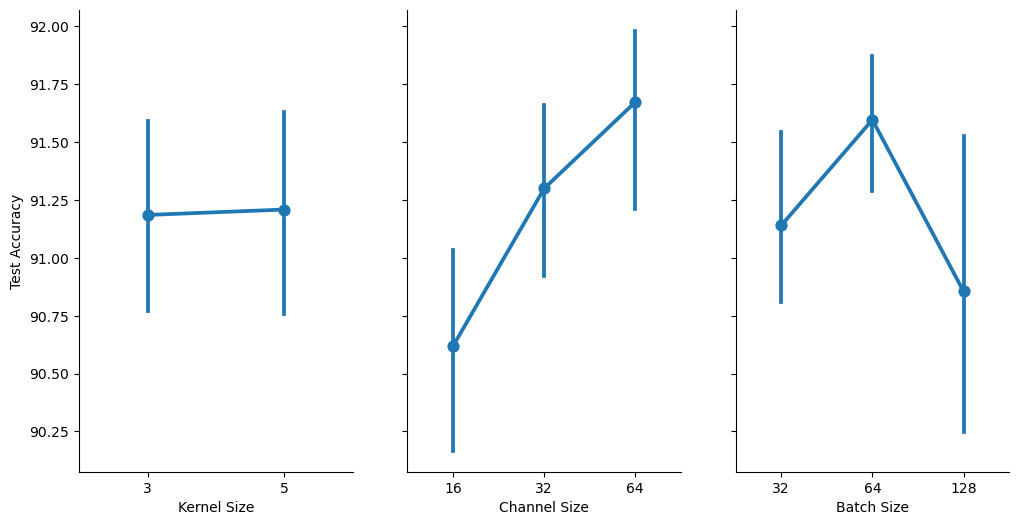

In [22]:
experiment_df = pd.DataFrame.from_dict(
    CNN_experiment_results,
    orient='index',
)

mosaic = [
    ['kernel_size', 'channel_size', 'batch_size'],
    ]

fig, ax = plt.subplot_mosaic(mosaic, figsize=(12, 6), sharey=True)

for config in np.array(mosaic).flatten():
    if config != '.':

        sns.pointplot(
            data=experiment_df,
            x=config,
            y='test_accuracy',
            ax=ax[config],
        )
        ax[config].spines[['right', 'top']].set_visible(False)
        ax[config].set_xlabel(
            ax[config].get_xlabel().replace('_', ' ').title()
        )
        ax[config].set_ylabel(
            ax[config].get_ylabel().replace('_', ' ').title()
        )
    

plt.subplots_adjust(hspace=0.4)
plt.show()

### Analysis of hyperparameter variation on the Model Predictive Performance_ **Predicitive Accuracy: **

Based on the plots for test_accuracy across different hyperparameter settings of kernel_size, channel_size, and batch_size, we can observe distinct trends and their potential impact on model performance:

**Kernel Size:**

kernel_size (between values of 3 and 5) have minimal impact on test_accuracy. The accuracy remains roughly consistent, hovering around 91%, with a slight variance represented by the error bars. 

**Channel Size:**

As channel_size grows from 16 to 64, there is a noticeable improvement in test_accuracy, reaching around 92% at the highest tested value of 64. This trend suggests that increasing the number of channels may enhance the model's capacity to learn more complex features, which in turn could improve predictive performance.

**Batch Size:**

Higher batch_size values, especially at 128, correspond with a decrease in accuracy. The accuracy drops from approximately 91.75% at a batch size of 64 to around 90.75% at 128. This decline might be due to a reduced gradient update frequency with larger batch sizes, which can sometimes prevent the model from converging optimally.

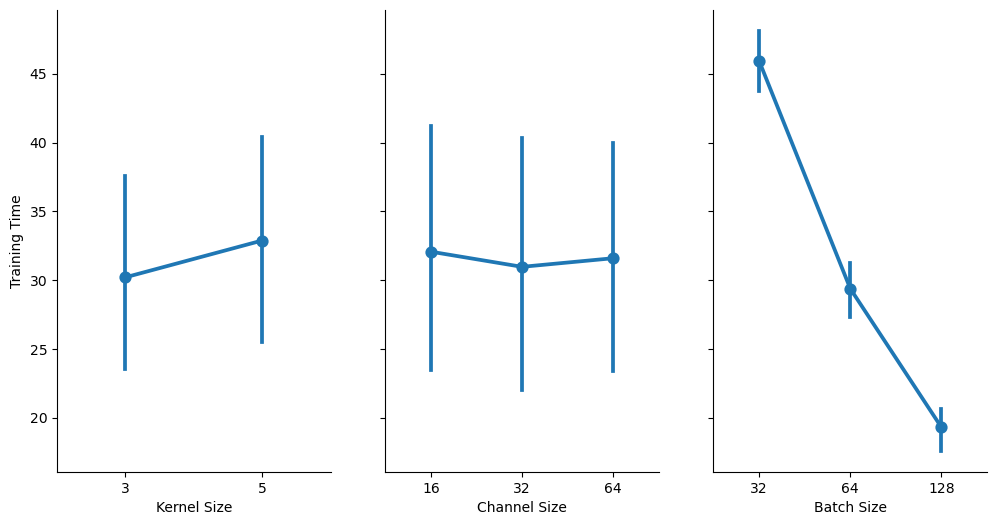

In [23]:
experiment_df = pd.DataFrame.from_dict(
    CNN_experiment_results,
    orient='index',
)

mosaic = [
    ['kernel_size', 'channel_size', 'batch_size'],
    ]

fig, ax = plt.subplot_mosaic(mosaic, figsize=(12, 6), sharey=True)

for config in np.array(mosaic).flatten():
    if config != '.':

        sns.pointplot(
            data=experiment_df,
            x=config,
            y='training_time',
            ax=ax[config],
        )
        ax[config].spines[['right', 'top']].set_visible(False)
        ax[config].set_xlabel(
            ax[config].get_xlabel().replace('_', ' ').title()
        )
        ax[config].set_ylabel(
            ax[config].get_ylabel().replace('_', ' ').title()
        )
    

plt.subplots_adjust(hspace=0.4)
plt.show()

### Analysis of hyperparameter variation on the Model Predictive Performance_ **Training Time: **


In analyzing the training_time across different hyperparameter settings of kernel_size, channel_size, and batch_size, several patterns emerge:

**Kernel Size:**

The training time seems to be somewhat consistent between the kernel sizes, with a slight dip at the kernel size of 3. However, there's considerable variation, as shown by the error bars, which suggests that factors other than kernel size might be influencing the training time. The training time increases slightly for kernel size 5, which may indicate that larger kernels take longer to compute.

**Channel Size:** 

The training time appears quite stable across different channel sizes, with no significant trend observed. Similar to kernel size, the error bars here are relatively wide, which implies variability in the results or other factors affecting the training time. The stability in training time across different channel sizes might suggest that channel size does not have a major impact on training duration in this particular model setup.

**Batch Size** :

A larger batch size, particularly 128, results in a notably faster training time. This trend is consistent with the fact that larger batch sizes lead to fewer iterations per epoch, thus reducing overall training time. However, as seen in the previous accuracy analysis, larger batch sizes may negatively impact model accuracy, so there’s a trade-off between efficiency and performance.